In [329]:
import Pkg
using DifferentialEquations
using SpecialFunctions
using Sundials
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
# set material properties
ρ_i = 910
K_c = 250000
c_r = 1500
ρ_w = 1000

# set shelf geometry
H_i = 100
H_w = 500
H_c = H_w - ρ_i/ρ_w*H_i
L_c = 10000

10000

In [ ]:
# define the bernoulli flow into a rift of fixed width and length (nonlinear momentum balance)
function bernoulli(du,u,p,t)
    H_i,H_w,H_c,L_c,w = p    
    η,ξ = u
    du[1] = ξ
    du[2] = (9.8*(H_w-H_c-η)-(1/2)*(1-(w/H_c)^2)*ξ^2)/(w*L_c/H_c+η)
end

# define the problem
u0 = [H_w-H_c;0]
tspan = (0,1000)
params = (H_i,H_w,H_c,L_c,w0)
ode_prob = ODEProblem(bernoulli,u0,tspan,params)

# solve the problem
ode_sol = solve(ode_prob,Tsit5(),reltol=1e-8,abstol=1e-8)

# plot the solution
plot(ode_sol, tspan=(0, 1000), layout=(2,1), size=(1000,500), labels=["η" "ξ"], linecolor=["red" "blue"])

In [ ]:
# formulate the bernoulli flow into a rift as a differential algebraic equation (nonlinear momentum balance)
function bernoulli_dae(out,du,u,p,t)
    H_i,H_w,H_c,L_c,w = p    
    η,ξ,v = u
    out[1] = ξ - du[1]
    out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    out[3] = w/H_c*ξ - v
end

# define the problem
u0 = [H_w-H_c, 0, 0]
du = [0, 0, 0]
tspan = (0,1000)
differential_vars = [true,true,true]
params = (H_i,H_w,H_c,L_c,w0)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())

# plot the solution
plot(dae_sol, tspan=(0, 1000), layout=(3,1), size=(1000,1000), labels=["η" "ξ" "v"], linecolor=["red" "blue" "green"])

In [ ]:
# bernoulli flow into a rift with a fixed rate of lengthening
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,w,dLdt = p    
    η,ξ,v,L = u
    
    # define differential variables
    out[1] = ξ - du[1]
    out[2] = dLdt - du[4]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    out[3] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    #out[3] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # write conservation of mass
    out[4] = 1/(L*H_c)*(w*L*ξ + w*η*dLdt) - v
    
end

# set initial conditions
w0 = 10
L0 = 1000
dLdt = 100
η0 = H_w-H_c
ξ0 = 0
v0 = 1/(L0*H_c)*(w0*L0*ξ0 + w0*η0*dLdt)
u0 = [η0, ξ0, v0, L0]
du = [0, 0, 0, dLdt]

# define the problem
tspan = (0,1000)
differential_vars = [true,true,true,true]
params = (H_i,H_w,H_c,L_c,w0,dLdt)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][4] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 1000), layout=(2,1), size=(1000,1000), labels=["η" "L"], linecolor=["red" "blue"])

In [ ]:
# uniformly-loaded linear elastic rift
function lefm_dae(out,du,u,p,t)
    
    # get parameters and variables
    c_r,K_c,σ = p
    L,K = u
    
    # define stress intensity factor
    out[1] = σ*sqrt(pi*L) - K
        
    # relate stress intensity factor to rate of length change
    if K >= K_c
        out[2] = c_r*(1-(K_c/K)^2) - du[1]
    elseif K < K_c
        out[2] = du[1]
    end
        
end

# set initial conditions
σ = 1500
L0 = 1000
K0 = σ*sqrt(pi*L0)
u0 = [L0, K0]
du = [0, 0]
    
# define the problem
tspan = (0,100)
differential_vars = [true,false]
params = (c_r,K_c,σ)
dae_prob = DAEProblem(lefm_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][2] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 100), layout=(2,1), size=(1000,1000), labels=["L" "K"], linecolor=["red" "blue"])

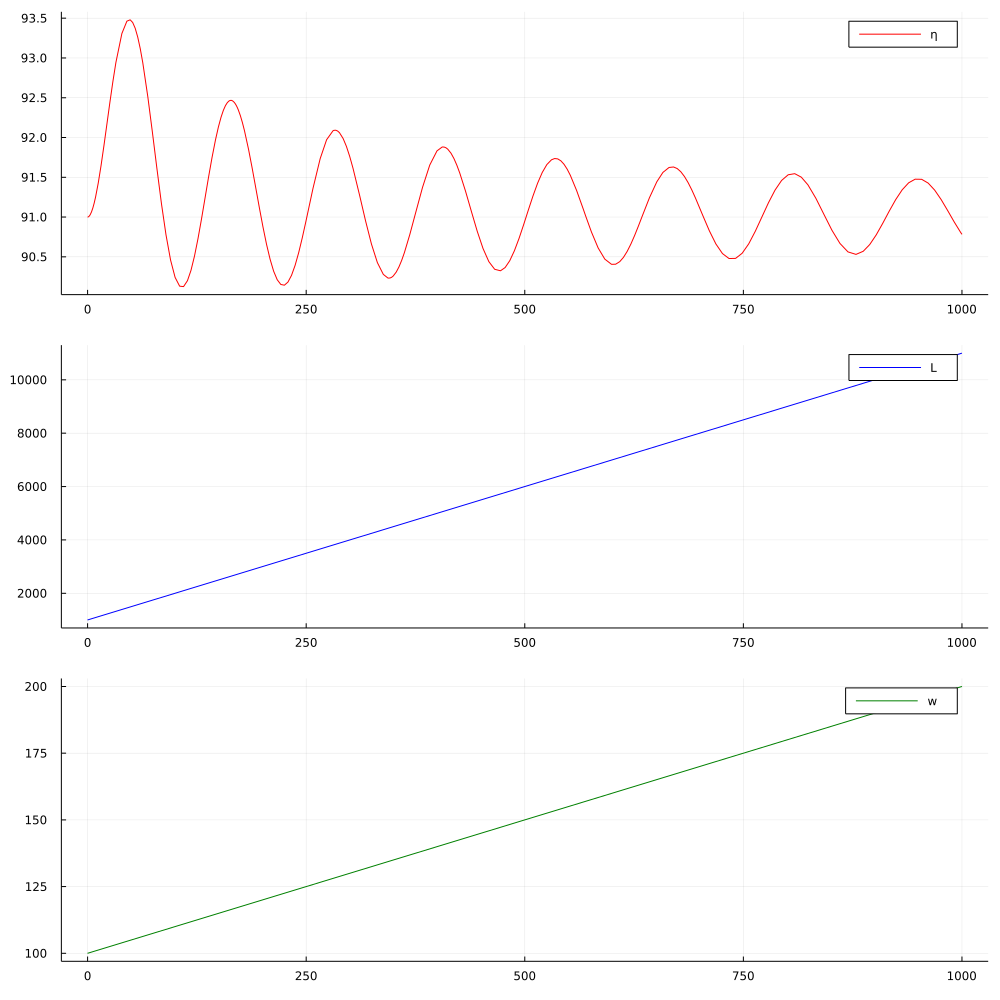

In [365]:
# bernoulli flow into a rift with a fixed rate of lengthening and widening
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,w,dLdt,dwdt = p    
    η,ξ,v,L,w = u
    
    # define differential variables
    out[1] = ξ - du[1]
    out[2] = dLdt - du[4]
    out[3] = dwdt - du[5]

    # write nonlinear conservation of momentum (bernoulli flow)
    #out[4] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    out[4] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # write conservation of mass
    out[5] = 1/(L*H_c)*(w*L*ξ + w*η*du[4] + η*L*du[5]) - v
end

# set initial conditions
w0 = 100
L0 = 1000
dLdt = 10
α = 0.01
dwdt = α * dLdt
η0 = H_w-H_c
ξ0 = 0
v0 = 1/(L0*H_c)*(w0*L0*ξ0 + w0*η0*dLdt + η0*L0*dwdt)
u0 = [η0, ξ0, v0, L0, w0]
du = [0, 0, 0, dLdt, dwdt]

# define the problem
tspan = (0,1000)
differential_vars = [true,true,true,true,true]
params = (H_i,H_w,H_c,L_c,w0,dLdt,dwdt)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][4] for u in tuples(dae_sol)],[u[1][5] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 1000), layout=(3,1), size=(1000,1000), labels=["η" "L" "w"], linecolor=["red" "blue" "green"])

In [ ]:
# bernoulli flow into a uniformly-loaded linear elastic rift with fixed width
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,w,c_r,K_c = p    
    η,ξ,v,L = u

    # define differential variables
    out[1] = ξ - du[1]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    #out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    out[2] = L_c*du[3] + H_w*du[2] - 9.8(H_w - H_c - η)
    
    # write conservation of mass
    out[3] = 1/(L*H_c)*(w*L*ξ + w*η*du[4]) - v
    
    # calculate stress as a function of time
    σ = stress(t)
    
    # relate stress intensity factor to rate of length change
    if σ^2*pi*L >= K_c^2
        out[4] = c_r*(1-K_c^2/(σ^2*pi*L)) - du[4]
    elseif σ^2*pi*L < K_c^2
        out[4] = du[4]
    end

end

# define function for stress through time
function stress(t)
    σ = 100*t
    return σ
end

# set initial conditions
w0 = 10
L0 = 1000
η0 = H_w-H_c
ξ0 = 0
v0 = 0
u0 = [η0, ξ0, v0, L0]
du = [0, 0, 0, 0]
#print("K0: ",σ*sqrt(pi*L0),"\nK_c: ",K_c)

# define the problem
tspan = (0,1000)
differential_vars = [true,true,true,true]
params = (H_i,H_w,H_c,L_c,w0,c_r,K_c)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][4] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 1000), layout=(2,1), size=(1000,1000), labels=["η" "L"], linecolor=["red" "blue"])

In [ ]:
# bernoulli flow into a uniformly-loaded linear elastic rift with widening rate proportional to lengthening rate
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,w,σ,c_r,K_c,α = p    
    η,ξ,v,L,w,K = u
    
    # define differential variables
    out[1] = ξ - du[1]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    #out[2] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # relate widening rate to lengthening rate by proportionality constant α
    out[3] = α*du[4] - du[5]
    
    # write conservation of mass
    out[4] = 1/(L*H_c)*(w*L*ξ + w*η*du[4] + η*L*du[5]) - v
    
    # define stress intensity factor
    out[5] = σ*sqrt(pi*L) - K
    
    # relate stress intensity factor to rate of length change
    if K >= K_c
        out[6] = c_r*(1-(K_c/K)^2) - du[4]
    elseif K < K_c
        out[6] = du[4]
    end
    
end


# set initial conditions
w0 = 10
L0 = 2000
σ = 4500
α = 0.01
η0 = H_w-H_c
ξ0 = 0
K0 = σ*sqrt(pi*L0)
dLdt = c_r*(1-(K_c/K0)^2)
dwdt = α*dLdt
v0 = 1/(L0*H_c)*(w0*L0*ξ0 + w0*η0*dLdt + η0*L0*dwdt)
u0 = [η0, ξ0, v0, L0, w0, K0]
du = [0, 0, 0, dLdt, dwdt, 0]

# define the problem
tspan = (0,1000)
differential_vars = [true,true,true,true,true,false]
params = (H_i,H_w,H_c,L_c,w0,σ,c_r,K_c,α)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][4] for u in tuples(dae_sol)],[u[1][5] for u in tuples(dae_sol)],[u[1][6] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 1000), layout=(4,1), size=(1000,1000), labels=["η" "L" "w" "K"], linecolor=["red" "blue" "green" "orange"])

In [ ]:
# bernoulli flow into a linear elastic rift with fixed width loaded by internal water pressure
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,w,c_r,K_c,ρ_i,ρ_w = p    
    η,ξ,v,L = u
    
    # define differential variables
    out[1] = ξ - du[1]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    #out[2] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # write conservation of mass
    out[3] = 1/(L*H_c)*(w*L*ξ + w*η*du[4]) - v
    
    # calculate depth-averaged stress acting on rift as a function of water level
    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #if η >= H_i
    #    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*H_i^2)/(2*H_i)
    #elseif η < H_i
    # N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #end
    
    # calculate stress as a function of time
    σ = stress(t) + N
    if σ < 0
        σ = 0
    end
    #print(σ,"\n")
    
    # relate stress intensity factor to rate of length change
    if σ^2*pi*L >= K_c^2
        out[4] = c_r*(1-K_c^2/(σ^2*pi*L)) - du[4]
    elseif σ^2*pi*L < K_c^2
        out[4] = du[4]
    end
    
end

# define function for stress through time
function stress(t)
    
    # linear increase
    #σ = 250*t
    
    # erf ramp to constant value
    #σ = erf(t)*150000
    
    # gaussian pulse
    σ = 250000*exp(-(t-250)^2 / 100^2)
    
    return σ
end

# set initial conditions
w0 = 10
L0 = 1000
η0 = H_w-H_c
ξ0 = 0
v0 = 0
u0 = [η0, ξ0, v0, L0]
du = [0, 0, 0, 0]

# define the problem
tspan = (0,1000)
differential_vars = [true,true,true,true]
params = (H_i,H_w,H_c,L_c,w0,c_r,K_c,ρ_i,ρ_w)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())
u = [[u[1][1] for u in tuples(dae_sol)],[u[1][4] for u in tuples(dae_sol)]]
t = dae_sol.t

# plot the solution
plot(t, u, tspan=(0, 10000), layout=(2,1), size=(1000,1000), labels=["η" "L"], linecolor=["red" "blue"])

In [426]:
# bernoulli flow into a linear elastic rift loaded by internal water pressure with widening rate proprtional to lengthening rate
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,c_r,K_c,ρ_i,ρ_w,α = p    
    η,ξ,v,L,w = u
    
    # define differential variables
    out[1] = ξ - du[1]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    #out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    out[2] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # relate widening rate to lengthening rate by proportionality constant α
    out[3] = α*du[4] - du[5]
    
    # write conservation of mass
    out[4] = 1/(L*H_c)*(w*L*ξ + w*η*du[4] + η*L*du[5]) - v

    # relate depth-averaged stress acting on rift to water level
    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #if η >= H_i
    #    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*H_i^2)/(2*H_i)
    #elseif η < H_i
    #    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #end
    
    # calculate stress as a function of time
    σ = stress(t) + N
    if σ < 0
        σ = 0
    end
    
    # relate stress intensity factor to rate of length change
    if σ^2*pi*L >= K_c^2
        out[5] = c_r*(1-K_c^2/(σ^2*pi*L)) - du[4]
    elseif σ^2*pi*L < K_c^2
        out[5] = du[4]
    end

end

# define function for stress through time
function stress(t)
    
    # linear increase
    #σ = 250*t
    
    # erf ramp to constant value
    σ = erf(t)*150000
    
    # gaussian pulse
    #σ = 250000*exp(-(t-250)^2 / 100^2)
    
    return σ
end

# set initial conditions
w0 = 10
L0 = 1000
α = 0.01
η0 = H_w-H_c
ξ0 = 0
v0 = 0
u0 = [η0, ξ0, v0, L0, w0]
du = [0, 0, 0, 0, 0]

# define the problem
tspan = (0,200)
differential_vars = [true,true,true,true,true]
params = (H_i,H_w,H_c,L_c,c_r,K_c,ρ_i,ρ_w,α)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())

# extract results
t = dae_sol.t
η = [u[1][1] for u in tuples(dae_sol)]
v = [u[1][3] for u in tuples(dae_sol)]
L = [u[1][4] for u in tuples(dae_sol)]

# calculate some useful values for understanding the results
w = [w0 + α*(Li - L0) for Li in L]
N = ρ_i*-9.8*H_i/2 .- (ρ_w*-9.8*η.^2)/(2*H_i)
σ = stress.(t) .+ N
σ[σ .< 0] .= 0
K = σ.*sqrt.(pi.*L)
K[K .< K_c] .= 0

# put all results and useful values in one vector
u = [η,v,L/1e3,w,σ,K/1e3]

# print some statistics
if L[end]-L[1] > 0
    L_growing = L[findall((L.-L[1]) .> 0)[1]:end]
    t_growing = t[findall((L.-L[1]) .> 0)[1]:end]
    print("Average velocity: ",(L_growing[end]-L_growing[1])/(t_growing[end]-t_growing[1])," m/s")
else
    print("Average velocity: 0 m/s")
end

# plot the solution
plot(t, u, tspan=(0, 1000), layout=(6,1), size=(1000,1000), 
    labels=["η" "v" "L" "w" "σ" "K"],
    linecolor=["red" "blue" "green" "orange" "purple" "teal"])

Average velocity: 334.26209715585543 m/s

In [427]:
# bernoulli flow into a linear elastic rift loaded by internal water pressure with widening rate proprtional to lengthening rate, neglecting dwdt from mass conservation
function bernoulli_dae(out,du,u,p,t)
    
    # get parameters and variables
    H_i,H_w,H_c,L_c,L0,w0,c_r,K_c,ρ_i,ρ_w,α = p    
    η,ξ,v,L = u
    
    # define differential variables
    out[1] = ξ - du[1]
    
    # write nonlinear conservation of momentum (bernoulli flow)
    #out[2] = L_c*du[3] + η*du[2] + 1/2*(ξ^2 - v^2) - 9.8(H_w - H_c - η)
    
    # write linearized conservation of momentum (bernoulli flow)
    out[2] = L_c*du[3] + H_w*du[2]  - 9.8(H_w - H_c - η)
    
    # relate width to length by proportionality constant α
    w = w0 + α*(L - L0)
    
    # write conservation of mass
    out[3] = 1/(L*H_c)*(w*L*ξ + w*η*du[4]) - v

    # relate depth-averaged stress acting on rift to water level
    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #if η >= H_i
    #    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*H_i^2)/(2*H_i)
    #elseif η < H_i
    #    N = ρ_i*-9.8*H_i/2 - (ρ_w*-9.8*η^2)/(2*H_i)
    #end
    
    # calculate stress as a function of time
    σ = stress(t) + N
    if σ < 0
        σ = 0
    end
    
    # relate stress intensity factor to rate of length change
    if σ^2*pi*L >= K_c^2
        out[4] = c_r*(1-K_c^2/(σ^2*pi*L)) - du[4]
    elseif σ^2*pi*L < K_c^2
        out[4] = du[4]
    end

end

# define function for stress through time
function stress(t)
    
    # linear increase
    #σ = 250*t
    
    # erf ramp to constant value
    σ = erf(t)*150000
    
    # gaussian pulse
    #σ = 250000*exp(-(t-250)^2 / 100^2)
    
    return σ
end

# set initial conditions
w0 = 10
L0 = 1000
α = 0.01
η0 = H_w-H_c
ξ0 = 0
v0 = 0
u0 = [η0, ξ0, v0, L0]
du = [0, 0, 0, 0]

# define the problem
tspan = (0,200)
differential_vars = [true,true,true,true]
params = (H_i,H_w,H_c,L_c,L0,w0,c_r,K_c,ρ_i,ρ_w,α)
dae_prob = DAEProblem(bernoulli_dae,du,u0,tspan,params,differential_vars=differential_vars)

# solve the problem
dae_sol = solve(dae_prob,IDA())

# extract results
t_no_dwdt = dae_sol.t
η_no_dwdt = [u_no_dwdt[1][1] for u_no_dwdt in tuples(dae_sol)]
v_no_dwdt = [u_no_dwdt[1][3] for u_no_dwdt in tuples(dae_sol)]
L_no_dwdt = [u_no_dwdt[1][4] for u_no_dwdt in tuples(dae_sol)]

# calculate some useful values for understanding the results
w_no_dwdt = [w0 + α*(Li - L0) for Li in L_no_dwdt]
N_no_dwdt = ρ_i*-9.8*H_i/2 .- (ρ_w*-9.8*η_no_dwdt.^2)/(2*H_i)
σ_no_dwdt = stress.(t_no_dwdt) .+ N_no_dwdt
σ_no_dwdt[σ_no_dwdt .< 0] .= 0
K_no_dwdt = σ_no_dwdt.*sqrt.(pi.*L_no_dwdt)
K_no_dwdt[K_no_dwdt .< K_c] .= 0

# put all results and useful values in one vector
u_no_dwdt = [η_no_dwdt,v_no_dwdt,L_no_dwdt/1e3,w_no_dwdt,σ_no_dwdt,K_no_dwdt/1e3]

# print some statistics
if L[end]-L[1] > 0
    L_growing = L_no_dwdt[findall((L_no_dwdt.-L_no_dwdt[1]) .> 0)[1]:end]
    t_growing = t_no_dwdt[findall((L_no_dwdt.-L_no_dwdt[1]) .> 0)[1]:end]
    print("Average velocity: ",(L_growing[end]-L_growing[1])/(t_growing[end]-t_growing[1])," m/s")
else
    print("Average velocity: 0 m/s")
end

# plot the solution
plot(t_no_dwdt, u_no_dwdt, tspan=(0, 1000), layout=(6,1), size=(1000,1500),xlim=[0,200],linecolor="black",left_margin = 15Plots.mm,
    plot_title=string("Comparison between DAE solutions with\n",L"v=1/(LH_c)(wL\xi + w\eta dLdt + \eta L dwdt)","\nand ",L"v=1/(LH_c)(wL\xi + w\eta dLdt)"),
    ylab = ["Water height (m)" "Distant flow (m/s)" "Crack length (km)" "Crack width (m)" "Loading (Pa)" "Stress intensity factor\n(KPa√m)"],
    labels=["η (no dwdt)" "v (no dwdt)" "L (no dwdt)" "w (no dwdt)" "σ (no dwdt)" "K (no dwdt)"])
plot!(t, u, linecolor="red",
    labels=["η (with dwdt)" "v (with dwdt)" "L (with dwdt)" "w (with dwdt)" "σ (with dwdt)" "K (with dwdt)"])
savefig("mass_conservation_comparison_zoom.png")

Average velocity: 670.4612512513414 m/s

In [428]:
# check how thesolver did
print("Exit code: ",dae_sol.retcode,"\n\n")
print(dae_sol.destats)

Exit code: Success

DiffEqBase.DEStats
Number of function 1 evaluations:                  119891
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    66955
Number of linear solves:                           0
Number of Jacobians created:                       66955
Number of nonlinear solver iterations:             119891
Number of nonlinear solver convergence failures:   22287
Number of rootfind condition calls:                0
Number of accepted steps:                          46100
Number of rejected steps:                          35